In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [28]:
# Define transformations with data augmentation (helped a lot for improving accuracy!!!)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Randomly flip images horizontally
    transforms.RandomRotation(10),     # Randomly rotate images by up to 10 degrees
    transforms.RandomResizedCrop(150, scale=(0.8, 1.0)), # Randomly crop and resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load dataset with transformations
dataset = datasets.ImageFolder(root='./strawberry_classify/dataset', transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Check the class distribution in the training and validation sets to ensure balance
train_class_counts = get_class_distribution(train_loader)
val_class_counts = get_class_distribution(val_loader)

print(f'Training set class distribution: {train_class_counts}')
print(f'Validation set class distribution: {val_class_counts}')

def get_class_distribution(loader):
    class_counts = [0, 0]  # Assuming two classes: 0 and 1
    for _, labels in loader:
        for label in labels:
            class_counts[label] += 1
    return class_counts

Training set class distribution: [207, 209]
Validation set class distribution: [56, 49]


In [29]:
class StrawberryCNN(nn.Module):
    def __init__(self):
        super(StrawberryCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 18 * 18, 128)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        return x

model = StrawberryCNN()

In [21]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [22]:
num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        labels = labels.float().view(-1, 1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            labels = labels.float().view(-1, 1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

Epoch 1/20, Train Loss: 0.3384, Validation Loss: 0.0586
Epoch 2/20, Train Loss: 0.1326, Validation Loss: 0.0441
Epoch 3/20, Train Loss: 0.1400, Validation Loss: 0.0377
Epoch 4/20, Train Loss: 0.0987, Validation Loss: 0.0160
Epoch 5/20, Train Loss: 0.0735, Validation Loss: 0.0205
Epoch 6/20, Train Loss: 0.0853, Validation Loss: 0.0173
Epoch 7/20, Train Loss: 0.0879, Validation Loss: 0.0273
Epoch 8/20, Train Loss: 0.0639, Validation Loss: 0.0137
Epoch 9/20, Train Loss: 0.0760, Validation Loss: 0.0161
Epoch 10/20, Train Loss: 0.0624, Validation Loss: 0.0161
Epoch 11/20, Train Loss: 0.0572, Validation Loss: 0.0166
Epoch 12/20, Train Loss: 0.0545, Validation Loss: 0.0105
Epoch 13/20, Train Loss: 0.0576, Validation Loss: 0.0134
Epoch 14/20, Train Loss: 0.0541, Validation Loss: 0.0250
Epoch 15/20, Train Loss: 0.0560, Validation Loss: 0.0159
Epoch 16/20, Train Loss: 0.0455, Validation Loss: 0.0101
Epoch 17/20, Train Loss: 0.0436, Validation Loss: 0.0149
Epoch 18/20, Train Loss: 0.0455, Validat

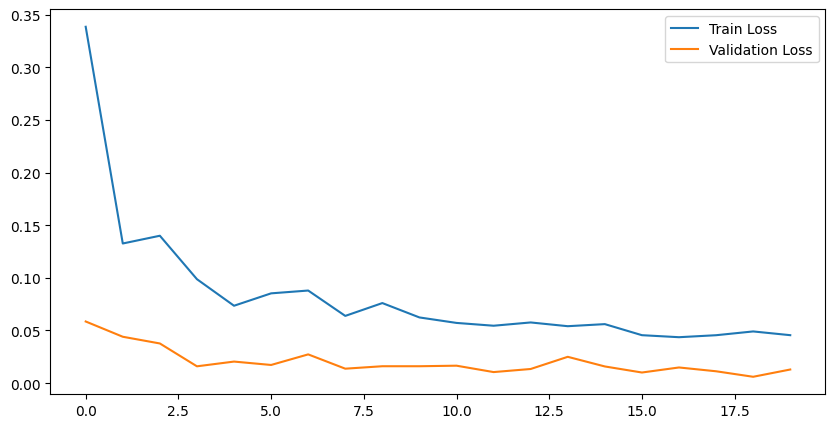

In [23]:
# Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

In [24]:
torch.save(model.state_dict(), 'strawberry_classifier.pth')

In [26]:
from PIL import Image

model = StrawberryCNN()
model.load_state_dict(torch.load('strawberry_classifier.pth'))
model.eval()

# Function to predict the ripeness of a strawberry
def predict_image(image_path, model):
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = transform(image).unsqueeze(0)
    
    with torch.no_grad():
        output = model(image)
        prediction = torch.round(output).item()
    
    if prediction == 0:
        return "Ripe"
    else:
        return "Unripe"

# Test the function (random strawberry images from google)
print(predict_image('./strawberry_classify/ripe-example-strawberry.jpg', model))
print(predict_image('./strawberry_classify/unripe-example-easy.jpg', model))

Ripe
Unripe
